In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_csv("Titanic-Dataset.csv")

df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pd.concat([X_train, y_train], axis=1).to_csv("titanic_train_data.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("titanic_test_data.csv", index=False)

categorical_features = ['Sex', 'Embarked', 'Pclass']
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8212290502793296
Confusion Matrix:
 [[91 14]
 [18 56]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



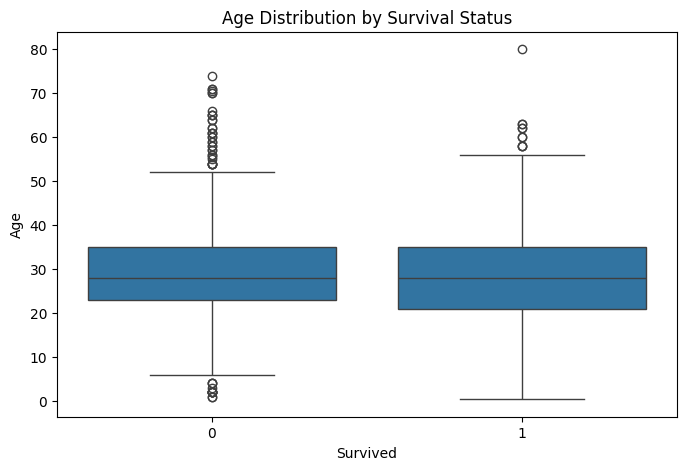

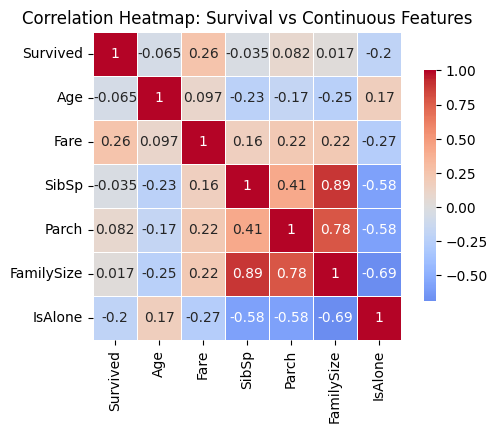

<Axes: xlabel='Importance', ylabel='Feature'>

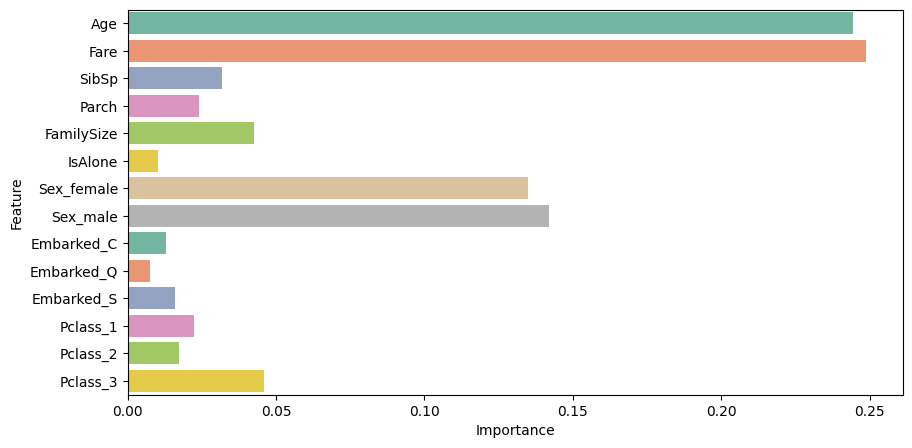

In [24]:
# Visualizations
plt.figure(figsize=(8, 5))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age Distribution by Survival Status')
plt.show()

plt.figure(figsize=(6, 4))
corr = df[['Survived', 'Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlation Heatmap: Survival vs Continuous Features')
plt.show()

importances = model.named_steps["classifier"].feature_importances_
from sklearn.compose import ColumnTransformer

cat_features = ['Sex', 'Embarked']
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']

raw_feature_names = model.named_steps["preprocessor"].get_feature_names_out()

clean_feature_names = [name.split("__")[-1] for name in raw_feature_names]

importance_df = pd.DataFrame({
    "Feature": clean_feature_names,
    "Importance": importances
})
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance",y="Feature",hue="Feature",data=importance_df, dodge=False,palette="Set2",legend=False)

In [25]:
joblib.dump(model, "titanic_model.pkl")

['titanic_model.pkl']

In [26]:
model = joblib.load("titanic_model.pkl")
print("\n--- Titanic Survival Prediction ---")
print("Please enter the following details:")

try:
    pclass = int(input("Ticket Class (1, 2, or 3): "))
    sex = input("Sex (male/female): ").strip().lower()
    age = float(input("Age (0-80): "))
    sibsp = int(input("Number of siblings/spouses aboard (0-8): "))
    parch = int(input("Number of parents/children aboard (0-6): "))
    fare = float(input("Fare paid (0-600): "))
    embarked = input("Port of Embarkation (C, Q, or S): ").strip().upper()

    family_size = sibsp + parch
    is_alone = 1 if family_size == 0 else 0

    user_input = pd.DataFrame([{
        "Pclass": pclass,
        "Sex": sex,
        "Age": age,
        "SibSp": sibsp,
        "Parch": parch,
        "Fare": fare,
        "Embarked": embarked,
        "FamilySize": family_size,
        "IsAlone": is_alone
    }])

    prediction = model.predict(user_input)[0]
    prob = model.predict_proba(user_input)[0]

    print("\nPrediction Result:")
    if prediction == 1:
        print("The passenger would have SURVIVED.")
    else:
        print("The passenger would NOT have survived.")

    print("\nModel Confidence (Survival vs Non-survival):")
    print(f"Survival Probability: {prob[1]:.2f}")
    print(f"Non-Survival Probability: {prob[0]:.2f}")

except Exception as e:
    print("\nError in input:", str(e))


--- Titanic Survival Prediction ---
Please enter the following details:


Ticket Class (1, 2, or 3):  2
Sex (male/female):  female
Age (0-80):  60
Number of siblings/spouses aboard (0-8):  0
Number of parents/children aboard (0-6):  0
Fare paid (0-600):  357
Port of Embarkation (C, Q, or S):  S



Prediction Result:
The passenger would have SURVIVED.

Model Confidence (Survival vs Non-survival):
Survival Probability: 0.92
Non-Survival Probability: 0.08
